In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import time
import sklearn
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.0
pandas 1.0.5
sklearn 0.23.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all,y_train_all),(x_test,y_test) = fashion_mnist.load_data()
x_valid,x_train = x_train_all[:5000],x_train_all[5000:]
y_valid,y_train = y_train_all[:5000],y_train_all[5000:]
print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1) # 1为通道数


In [4]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation='relu'))
model.add(keras.layers.Dense(10,activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy",optimizer='sgd',metrics=["accuracy"])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [6]:
logdir = 'cnn-relu-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,"fashion_mnist_model.h5")

callbacks = [keras.callbacks.TensorBoard(logdir),
             keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
             keras.callbacks.EarlyStopping(patience=15,min_delta=1e-10)]

history = model.fit(x_train_scaled,y_train,epochs=10,validation_data=(x_valid_scaled,y_valid),callbacks=callbacks)


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 247s 4ms/sample - loss: 0.7784 - accuracy: 0.7179 - val_loss: 0.4626 - val_accuracy: 0.8234
Epoch 2/10
55000/55000 [==============================] - 236s 4ms/sample - loss: 0.4007 - accuracy: 0.8525 - val_loss: 0.3316 - val_accuracy: 0.8798
Epoch 3/10
55000/55000 [==============================] - 251s 5ms/sample - loss: 0.3409 - accuracy: 0.8746 - val_loss: 0.3324 - val_accuracy: 0.8782
Epoch 4/10
55000/55000 [==============================] - 246s 4ms/sample - loss: 0.3056 - accuracy: 0.8881 - val_loss: 0.3107 - val_accuracy: 0.8876
Epoch 5/10
55000/55000 [==============================] - 240s 4ms/sample - loss: 0.2783 - accuracy: 0.8991 - val_loss: 0.2750 - val_accuracy: 0.9010
Epoch 6/10
55000/55000 [==============================] - 234s 4ms/sample - loss: 0.2583 - accuracy: 0.9056 - val_loss: 0.2718 - val_accuracy: 0.9028
Epoch 7/10
55000/55000 [===========================

In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

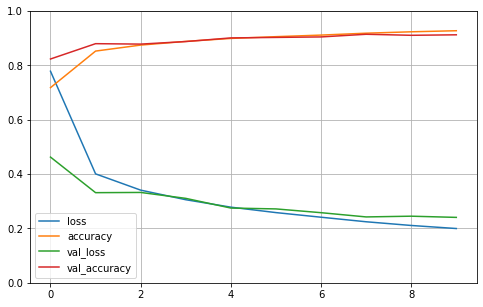

In [10]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)

In [11]:
model.evaluate(x_test_scaled,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.26784346804618836, 0.905]

In [ ]:
# tensorboard 展示，命令行下执行，注意：文件目录
# tensorboard --logdir=callbacks

In [ ]:
def make_dataset(images,labels,epochs,batch_size,shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images,labels))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch_size(batch_size).prefecth(50)
    return dataset
